# Proyecto: Análisis del mercado inmobiliario de la Ciudad de Buenos Aires


Mentor: Javier Lezama.

javitolez@gmail.com

En este proyecto vamos a trabajar con un dataset de propiedades en venta publicadas en el portal www.Properati.com.ar.

# El dataset: propiedades en venta en Ciudad de Buenos Aires.

En este proyecto, trabajaremos con una muestra del conjunto de datos de propiedades en venta mencionado. En este dataset, cada fila es una propiedad en venta. 

#Los atributos

A continuación vamos a describir los atributos que consideramos en esta muestra:
* id: id de la propiedad
* created_on: fecha en la que la propiedad ingresó al sitio
* operation: alquiler (rent) o venta (sell)
* property_type: tipo de propiedad (casa, departamento, ph, etcétera)
* place_with_parent_names: nombre del lugar donde se encuentra la propiedad según el publicador
* lat-lon: coordenadas concatenadas
* lat: latitud
* lon: longitud
* price: precio en la moneda especificada en currency
* currency: divisa en la que está expresada la publicación
* price_aprox_usd: precio aproximado en dólares estadounidenses
* surface_total_in_m2: superficie total (en metros cuadrados)
* surface_covered_in_m2: superficie cubierta (en metros cuadrados)
* price_usd_per_m2: precio por metro cuadrado en dólares (precio dólares / superficie)
* floor: número de piso (si corresponde)
* rooms: cantidad de ambientes
* expenses: expensas (si corresponde)
* barrio: barrio según cartografía oficial
* properati_url: url de la publicación en Properati

Objetivos del practico aprendizaje no supervisado:

El objetivo de este práctico es trabajar con el dateset original y realizar un algoritmo de clustering, k-means, y analizar el mismo, con las herramientas vistas en clases.

# Manos a la obra

In [1]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import silhouette_samples, silhouette_score

#from ml.visualization import plot_confusion_matrix, plot_learning_curve
#from sklearn.datasets import load_wine
#from sklearn.linear_model import SGDClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(1234) # Para mayor determinismo

In [2]:
df_prop = pd.read_csv('datos_properati.csv')
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 17 columns):
created_on                 18979 non-null object
operation                  18979 non-null object
property_type              18979 non-null object
place_with_parent_names    18979 non-null object
lat-lon                    18979 non-null object
lat                        18979 non-null float64
lon                        18979 non-null float64
price_aprox_usd            17445 non-null float64
surface_total_in_m2        16586 non-null float64
surface_covered_in_m2      16876 non-null float64
price_usd_per_m2           16037 non-null float64
floor                      2756 non-null float64
rooms                      13517 non-null float64
expenses                   3815 non-null float64
properati_url              18979 non-null object
barrio                     18979 non-null object
comuna                     18979 non-null float64
dtypes: float64(10), object(7)
memory usage: 2.5+ 

In [3]:
df_prop.head(4)

,created_on,operation,property_type,place_with_parent_names,lat-lon,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,barrio,comuna
0,2017-09-22,sell,house,|Argentina|Capital Federal|Palermo|Palermo Viejo|,"-34.5889531469,-58.4298817776",-34.588953,-58.429882,2000000.0,312.0,NaN,6410.256410,NaN,NaN,NaN,https://www.properati.com.ar/2os_venta_casa_pa...,PALERMO,14.0
1,2017-08-01,sell,store,|Argentina|Capital Federal|Palermo|,"-34.586069,-58.414431",-34.586069,-58.414431,790000.0,121.0,121.0,6528.925620,NaN,NaN,NaN,https://www.properati.com.ar/1cl7l_venta_local...,PALERMO,14.0
2,2017-08-02,sell,store,|Argentina|Capital Federal|Palermo|Palermo Soho|,"-34.589723,-58.4325664",-34.589723,-58.432566,343000.0,122.0,108.0,2811.475410,NaN,2.0,NaN,https://www.properati.com.ar/1cm8w_venta_local...,PALERMO,14.0
3,2017-08-03,sell,store,|Argentina|Capital Federal|Palermo|,"-34.5923646,-58.4144028",-34.592365,-58.414403,145000.0,24.0,24.0,6041.666667,NaN,NaN,NaN,https://www.properati.com.ar/1covk_venta_local...,PALERMO,14.0


Se eliminan aquellas features que no son numericas ni categoricas. Se definen que variables son las importantes para poder predecir el tipo de propiedad.

In [4]:
df_prop_t = df_prop[['property_type','price_aprox_usd','price_usd_per_m2','surface_total_in_m2','rooms','surface_covered_in_m2']]
df_prop_t.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,house,2000000.0,6410.256410,312.0,NaN,NaN
1,store,790000.0,6528.925620,121.0,NaN,121.0
2,store,343000.0,2811.475410,122.0,2.0,108.0
3,store,145000.0,6041.666667,24.0,NaN,24.0
4,store,175000.0,7291.666667,24.0,NaN,24.0


In [5]:
df_prop_t.shape

(18979, 6)

In [6]:
df_prop_t_na = df_prop_t.dropna()

Para este analisis se define eliminar nulos ya que no se puede predecir sin valores.

In [7]:
df_prop_t_na.shape

(12059, 6)

In [8]:
df_prop_t_na.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
2,store,343000.0,2811.475410,122.0,2.0,108.0
10,store,220000.0,7096.774194,31.0,1.0,31.0
18,apartment,340000.0,2615.384615,130.0,4.0,120.0
19,apartment,222000.0,4269.230769,52.0,1.0,48.0
22,house,1200000.0,2255.639098,532.0,6.0,334.0


Analizamos un poco los datos seleccionados, teniendo como objetivo del clustering diferenciar los tipos de propiedad. Ver cuan balanceada estan las clases

In [9]:
df_group=df_prop_t_na.groupby('property_type')

In [10]:
df_group.size()

property_type
PH             990
apartment    10337
house          648
store           84
dtype: int64

Al ser tan pocos se eliminan las propiedades "store"

In [11]:
filter=['PH','apartment','house']
df_prop_t_na=df_prop_t_na[df_prop_t_na['property_type'].isin(filter)]

In [12]:
df_group=df_prop_t_na.groupby('property_type')

Observamos que estan muy desbalanceadas para los departamentos. Tomando la variable property_type = 'PH': 0, 'apartment': 1, 'house': 2

In [13]:
df_group.size()

property_type
PH             990
apartment    10337
house          648
dtype: int64

Procesamos los barrios y tipos propiedad para pasarlos a variables numericas

In [14]:
labelEncoderP = LabelEncoder()
labelEncoderB = LabelEncoder()
labelEncoderP.fit(df_prop_t_na['property_type'])
df_prop_t_na['property_type'] = labelEncoderP.transform(df_prop_t_na['property_type'])
df_prop_t_na.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
18,1,340000.0,2615.384615,130.0,4.0,120.0
19,1,222000.0,4269.230769,52.0,1.0,48.0
22,2,1200000.0,2255.639098,532.0,6.0,334.0
24,1,270000.0,4029.850746,67.0,3.0,64.0
29,1,250000.0,3731.343284,67.0,2.0,60.0


In [15]:
df_prop_t_na = df_prop_t_na.reset_index(drop=True)
df_prop_t_na.head(5)

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,1,340000.0,2615.384615,130.0,4.0,120.0
1,1,222000.0,4269.230769,52.0,1.0,48.0
2,2,1200000.0,2255.639098,532.0,6.0,334.0
3,1,270000.0,4029.850746,67.0,3.0,64.0
4,1,250000.0,3731.343284,67.0,2.0,60.0


In [16]:
df_prop_t_na.groupby('property_type').size()

property_type
0      990
1    10337
2      648
dtype: int64

# Ejercicio

Realizar un algoritmo de clustering, k-means, subre algunos de los labels del dataset original y analizar el mismo. Comparar la cantidad de clusters obtenidos con los reales, asignar etiquetas a los clusters en función de las clases, usar la medida de pureza para comparar cuantitativamente diferentes soluciones, describir el contenido de los clusters, describiendo: qué une en un mismo cluster elementos de distintas clases, por qué se separa la misma clase en diferentes clusters.

Analizar la creación de un embedding (puede ser PCA pero también otro) para obtener otra tanda de soluciones de custering, realizar el mismo análisis sobre esta segunda aproximación, y comparar entre ambas, cuál sería mejor.



#### Kmeans

In [17]:
#x es el conjunto de features
X_prop = df_prop_t_na.drop('property_type', axis=1).astype(float)

#y es la columna target que se desea predecir
y_prop = df_prop_t_na['property_type']

In [18]:
X_prop.head()

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,340000.0,2615.384615,130.0,4.0,120.0
1,222000.0,4269.230769,52.0,1.0,48.0
2,1200000.0,2255.639098,532.0,6.0,334.0
3,270000.0,4029.850746,67.0,3.0,64.0
4,250000.0,3731.343284,67.0,2.0,60.0


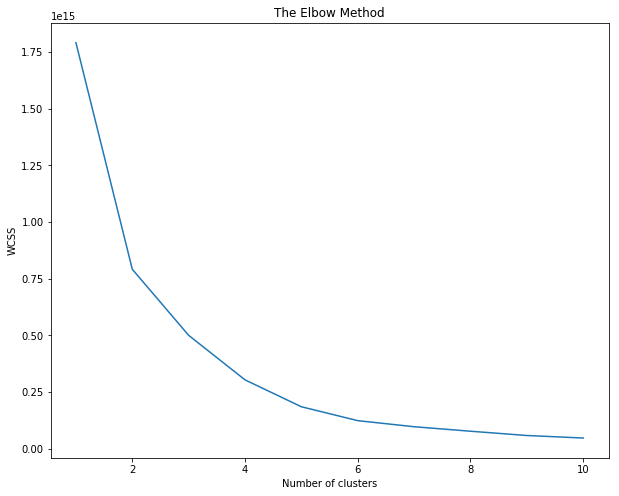

In [19]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
sse={}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(X_prop)
    sse[i]=kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Para n_clusters = 2 El silhouette_score promedio es : 0.8496143621819137


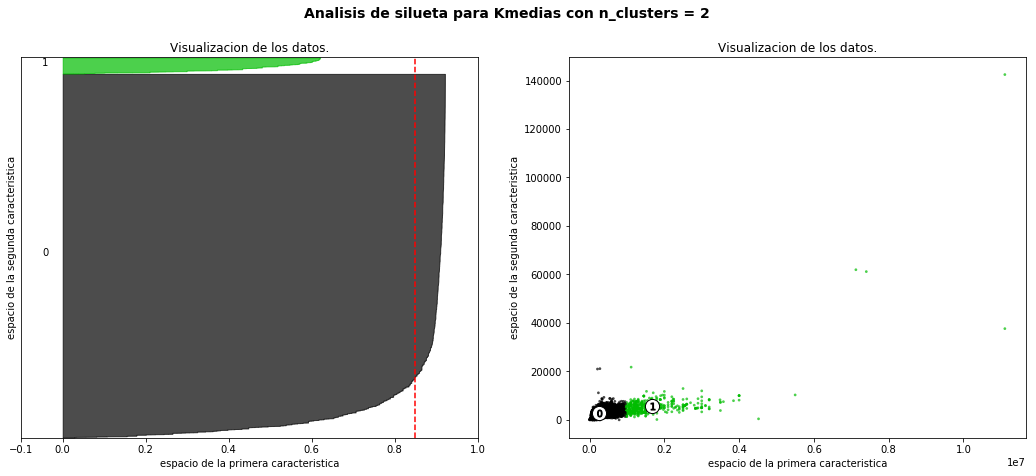

In [20]:
random_state = 42
range_n_clusters = [2]
sse ={}
for clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_prop) + (clusters + 1) * 10])


    kmeans = KMeans(n_clusters=clusters, random_state=random_state)

    y_pred = kmeans.fit_predict(X_prop)

    sse[clusters] = kmeans.inertia_
    silhouette_avg = silhouette_score(X_prop, y_pred)

    print("Para n_clusters =", clusters,
              "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_prop, y_pred)

    y_lower = 10
    for i in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_pred.astype(float) / clusters)
    ax2.scatter(X_prop.iloc[:, 0], X_prop.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
        c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                    "con n_clusters = %d" % clusters),
                    fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)
    plt.show()

Segun lo que se observa el algoritmo no logra detectar las 3 clases. Con el analisis del codo no se observa ningun "codo" por lo que no se puede identificar las clases.

Se puede entender que como las clases estan tan desbalanceadas el detectar 2 clusters es la mejor opcion de clusters, ya que el silhouette_score promedio es : 0.8496143621819137 y es el mas alto

In [21]:

kmeans = KMeans(n_clusters=clusters, random_state=random_state)
y_pred = kmeans.fit_predict(X_prop)

y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
X_prop_clu = X_prop.copy()
X_prop_clu['cluster'] = cluster
#Count of clusters
kmeans_count_cluster = pd.DataFrame(X_prop_clu.groupby('cluster').count())
kmeans_count_cluster
#df_prop_t_na.head(50)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
cluster,,,,,
1,11472,11472,11472,11472,11472
2,503,503,503,503,503


In [22]:
kmeans_mean_cluster = pd.DataFrame(X_prop_clu.groupby('cluster').mean())
kmeans_mean_cluster

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
cluster,,,,,
1,2.402084e+05,2683.899590,132.064156,2.925819,115.309013
2,1.680425e+06,5903.992104,368.363817,5.443340,296.021869


Segun observamos la division de las dos clases se hace por valores variados de las variables. El cluster 1 que al ser la mayoria se lo puede considerar como departamentos y el 2 como casas y PH. El 1 tiene algunos valores que diferencia mucho de la otra clase. Por ejemplo, el tamaño total y cubierto y habitaciones promedio de las propiedades , son menos de la mitad para un departamento que para una casa/PH.

In [23]:
X_prop_comp=X_prop_clu.copy()
X_prop_comp['property_type']=y_prop
X_prop_comp.head(5)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2,cluster,property_type
0,340000.0,2615.384615,130.0,4.0,120.0,1,1
1,222000.0,4269.230769,52.0,1.0,48.0,1,1
2,1200000.0,2255.639098,532.0,6.0,334.0,2,2
3,270000.0,4029.850746,67.0,3.0,64.0,1,1
4,250000.0,3731.343284,67.0,2.0,60.0,1,1


Media de valores por property_type.
Se observa que todos los PH los predijo como parte de la clase 1.

In [24]:
X_prop_comp_mean = pd.DataFrame(X_prop_comp.groupby('property_type').mean())
X_prop_comp_mean

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2,cluster
property_type,,,,,,
0,223982.393879,1819.744432,258.236364,3.859596,225.219192,1.000000
1,297306.920604,2976.886157,104.166683,2.837671,92.724291,1.044307
2,472100.296991,1829.915013,567.750000,4.859568,447.941358,1.069444


In [25]:
X_prop_comp_comparado = X_prop_comp
X_prop_comp_comparado['misma_clase'] = np.where(X_prop_comp_comparado.cluster == X_prop_comp_comparado.property_type, 'True', 'False')
X_prop_comp_comparado.head(5)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2,cluster,property_type,misma_clase
0,340000.0,2615.384615,130.0,4.0,120.0,1,1,True
1,222000.0,4269.230769,52.0,1.0,48.0,1,1,True
2,1200000.0,2255.639098,532.0,6.0,334.0,2,2,True
3,270000.0,4029.850746,67.0,3.0,64.0,1,1,True
4,250000.0,3731.343284,67.0,2.0,60.0,1,1,True


In [26]:
X_prop_comp_comparado.shape

(11975, 8)

In [27]:
X_prop_comp_comparado=X_prop_comp_comparado.groupby('misma_clase')
X_prop_comp_comparado.size()

misma_clase
False    2051
True     9924
dtype: int64

In [28]:
percentage_pred = 9924 * 100 / 11975
percentage_pred

82.87265135699374

**** Para aplicar el kmeans eficientemente, debemos escalar las variables para que sean comparables entre ellas ya que se necesita calcular la distancia euclidea. ****

In [29]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#X_prop_stand = StandardScaler().fit_transform(X_prop)

X_prop_stand = preprocessing.scale(X_prop)
X_prop_stand = pd.DataFrame(X_prop_stand)

In [30]:
X_prop_stand

,0,1,2,3,4
0,0.101619,-0.104416,-0.005899,0.579632,-0.001633
1,-0.203525,0.743038,-0.044275,-1.215942,-0.042169
2,2.325547,-0.288754,0.191886,1.776681,0.118851
3,-0.079398,0.620376,-0.036895,-0.018893,-0.033161
4,-0.131118,0.467417,-0.036895,-0.617418,-0.035413
5,0.489514,1.066253,-0.020659,0.579632,-0.015708
6,-0.469556,0.081454,-0.050179,-1.215942,-0.048925
7,5.945896,1.886115,0.126941,1.178157,0.156010
8,0.567092,1.302386,-0.022135,-0.018893,-0.014582
9,4.329669,0.755463,0.156461,1.776681,0.156010


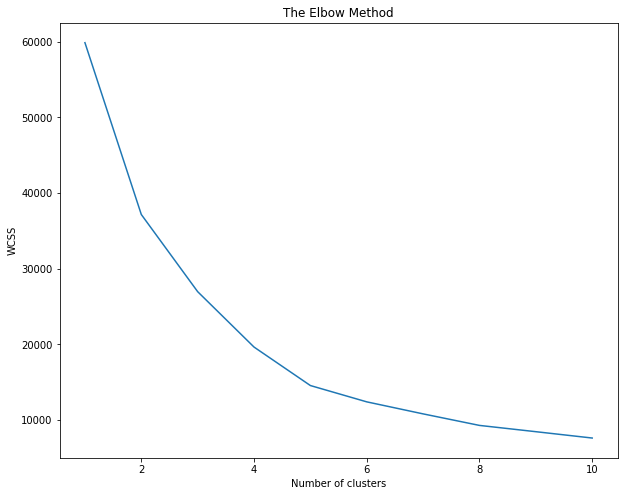

In [31]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
sse={}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(X_prop_stand)
    sse[i]=kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Segun el resultado se puede observar una division mas dificil de ver, apenas marcada en el cluster 2 y 5

Para n_clusters = 2 El silhouette_score promedio es : 0.9844060336893705


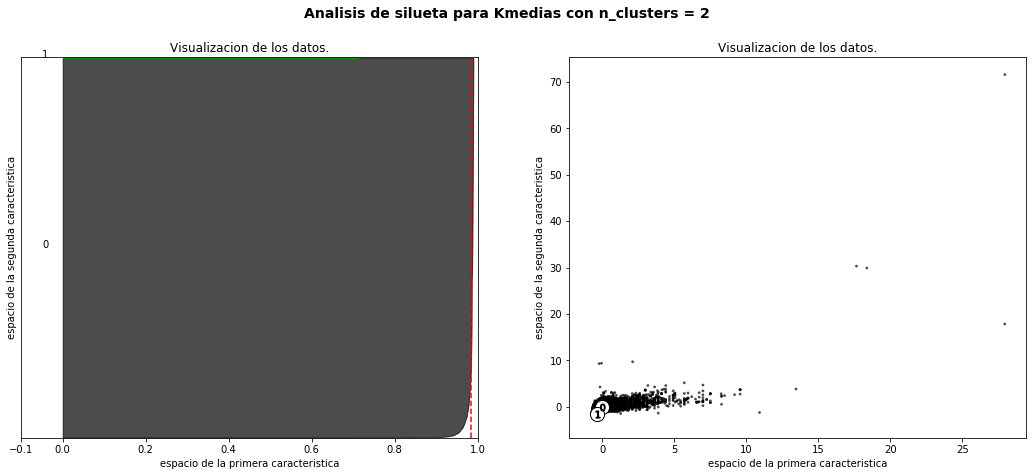

Para n_clusters = 5 El silhouette_score promedio es : 0.4359466514129731


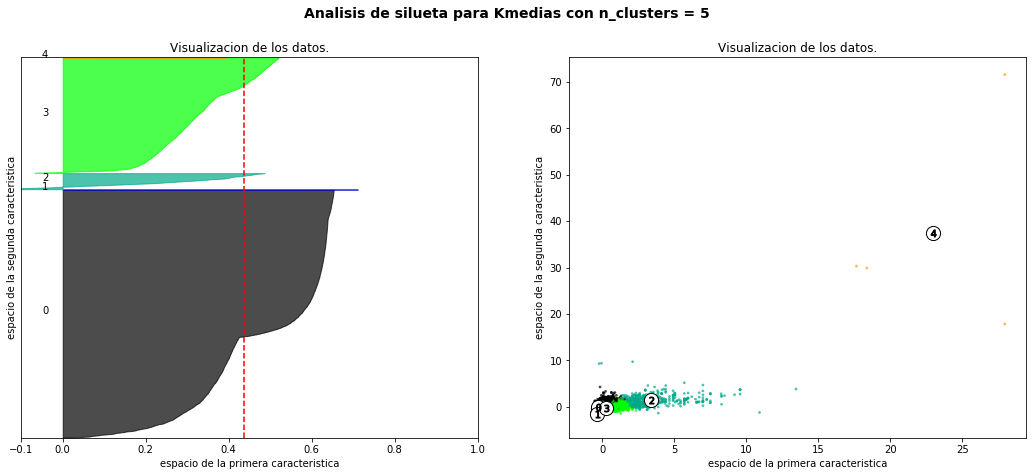

In [32]:
random_state = 42
range_n_clusters = [2,5]
sse ={}
for clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_prop_stand) + (clusters + 1) * 10])


    kmeans = KMeans(n_clusters=clusters, random_state=random_state)

    y_pred = kmeans.fit_predict(X_prop_stand)

    sse[clusters] = kmeans.inertia_
    silhouette_avg = silhouette_score(X_prop_stand, y_pred)

    print("Para n_clusters =", clusters,
              "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_prop_stand, y_pred)

    y_lower = 10
    for i in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_pred.astype(float) / clusters)
    ax2.scatter(X_prop_stand.iloc[:, 0], X_prop_stand.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
        c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                    "con n_clusters = %d" % clusters),
                    fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)
    plt.show()

In [33]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, random_state = 42)
y_pred = kmeans.fit_predict(X_prop_stand)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
X_prop_stand_fin = X_prop_stand.copy()
X_prop_stand_fin['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(X_prop_stand_fin.groupby('cluster').count())
kmeans_mean_cluster
#df_prop_t_na.head(50)

,0,1,2,3,4
cluster,,,,,
1,11973,11973,11973,11973,11973
2,2,2,2,2,2


In [34]:
X_prop_stand_fin['property_type']=y_prop
X_prop_stand_fin

,0,1,2,3,4,cluster,property_type
0,0.101619,-0.104416,-0.005899,0.579632,-0.001633,1,1
1,-0.203525,0.743038,-0.044275,-1.215942,-0.042169,1,1
2,2.325547,-0.288754,0.191886,1.776681,0.118851,1,2
3,-0.079398,0.620376,-0.036895,-0.018893,-0.033161,1,1
4,-0.131118,0.467417,-0.036895,-0.617418,-0.035413,1,1
5,0.489514,1.066253,-0.020659,0.579632,-0.015708,1,1
6,-0.469556,0.081454,-0.050179,-1.215942,-0.048925,1,1
7,5.945896,1.886115,0.126941,1.178157,0.156010,1,1
8,0.567092,1.302386,-0.022135,-0.018893,-0.014582,1,1
9,4.329669,0.755463,0.156461,1.776681,0.156010,1,2


Segun las cantidades, podemos observar como el cluster nro 1 representa a los departamentos que son en su mayoria del conjunto de datos y el 2 a algo que no es departamento, osea house y PH.

Segun lo que se observa el algoritmo no logra detectar las 3 clases. Con el analisis del codo no se observa ningun "codo" por lo que no se puede identificar las clases.

Se puede entender que como las clases estan tan desbalanceadas el detectar 2 clusters es la mejor opcion de clusters, ya que el silhouette_score promedio es : 0.9844060336893705 y detecta casi la totalidad de los ejemplos a una clase y muy pocos en otra.

No mejora la clusterización estandarizando, ya que casi todo es de una clase

In [35]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, random_state = 42)
y_pred = kmeans.fit_predict(X_prop_stand)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
X_prop_stand_fin['cluster_5'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(X_prop_stand_fin.groupby('cluster_5').count())
kmeans_mean_cluster
#df_prop_t_na.head(50)

,0,1,2,3,4,cluster,property_type
cluster_5,,,,,,,
1,7831,7831,7831,7831,7831,7831,7831
2,2,2,2,2,2,2,2
3,509,509,509,509,509,509,509
4,3629,3629,3629,3629,3629,3629,3629
5,4,4,4,4,4,4,4


Usando el 5 como clusters, se observa que hay 2 clusters que practicamente no tienen ejemplos (2 y 5) y se podria tomar el 1 como Departamentos, ya que es el de mayor porcentaje de ejemplos pero el resto no se podria identificar la clase.

### Embendings

Aplicamos ***Feature Selection*** 

con metodo de la varianza

In [36]:
df_prop_feat_sel = df_prop_t_na
df_prop_feat_sel.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,1,340000.0,2615.384615,130.0,4.0,120.0
1,1,222000.0,4269.230769,52.0,1.0,48.0
2,2,1200000.0,2255.639098,532.0,6.0,334.0
3,1,270000.0,4029.850746,67.0,3.0,64.0
4,1,250000.0,3731.343284,67.0,2.0,60.0


In [37]:
df_prop_feat_sel = df_prop_t_na.drop("property_type",axis=1)
df_prop_feat_sel.head()

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,340000.0,2615.384615,130.0,4.0,120.0
1,222000.0,4269.230769,52.0,1.0,48.0
2,1200000.0,2255.639098,532.0,6.0,334.0
3,270000.0,4029.850746,67.0,3.0,64.0
4,250000.0,3731.343284,67.0,2.0,60.0


In [38]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8*(1-.8)))
df_tranf_feat_sel = pd.DataFrame(sel.fit_transform(df_prop_feat_sel))
df_tranf_feat_sel.head(5)

,0,1,2,3,4
0,340000.0,2615.384615,130.0,4.0,120.0
1,222000.0,4269.230769,52.0,1.0,48.0
2,1200000.0,2255.639098,532.0,6.0,334.0
3,270000.0,4029.850746,67.0,3.0,64.0
4,250000.0,3731.343284,67.0,2.0,60.0


Observamos que no achico el numero de variables con diferentes varianzas probadas.

In [39]:
X_prop_stand_feat_sel = X_prop_stand
X_prop_stand_feat_sel.head()

,0,1,2,3,4
0,0.101619,-0.104416,-0.005899,0.579632,-0.001633
1,-0.203525,0.743038,-0.044275,-1.215942,-0.042169
2,2.325547,-0.288754,0.191886,1.776681,0.118851
3,-0.079398,0.620376,-0.036895,-0.018893,-0.033161
4,-0.131118,0.467417,-0.036895,-0.617418,-0.035413


In [40]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8*(1-.8)))
X_prop_stand_tranf_feat_sel = pd.DataFrame(sel.fit_transform(X_prop_stand_feat_sel))
X_prop_stand_tranf_feat_sel.head(5)

,0,1,2,3,4
0,0.101619,-0.104416,-0.005899,0.579632,-0.001633
1,-0.203525,0.743038,-0.044275,-1.215942,-0.042169
2,2.325547,-0.288754,0.191886,1.776681,0.118851
3,-0.079398,0.620376,-0.036895,-0.018893,-0.033161
4,-0.131118,0.467417,-0.036895,-0.617418,-0.035413


Tampoco usando el dataset estandarizado

Aplicamos ***SelectKBest***

In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = df_prop_t_na.drop("property_type",axis=1), df_prop_t_na.property_type
X.head(5)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,340000.0,2615.384615,130.0,4.0,120.0
1,222000.0,4269.230769,52.0,1.0,48.0
2,1200000.0,2255.639098,532.0,6.0,334.0
3,270000.0,4029.850746,67.0,3.0,64.0
4,250000.0,3731.343284,67.0,2.0,60.0


In [42]:
y.head(5)

0    1
1    1
2    2
3    1
4    1
Name: property_type, dtype: int32

In [43]:
X_new = SelectKBest(chi2, k=4).fit_transform(X, y)
X_new

array([[3.40000000e+05, 2.61538462e+03, 1.30000000e+02, 1.20000000e+02],
       [2.22000000e+05, 4.26923077e+03, 5.20000000e+01, 4.80000000e+01],
       [1.20000000e+06, 2.25563910e+03, 5.32000000e+02, 3.34000000e+02],
       ...,
       [9.90000000e+04, 8.60869565e+02, 1.15000000e+02, 8.20000000e+01],
       [5.04330100e+04, 1.12073356e+03, 4.50000000e+01, 4.50000000e+01],
       [7.50000000e+04, 1.25000000e+03, 6.00000000e+01, 5.80000000e+01]])

In [44]:
x_prop_kbest = pd.DataFrame(X_new)
x_prop_kbest.head(5)

,0,1,2,3
0,340000.0,2615.384615,130.0,120.0
1,222000.0,4269.230769,52.0,48.0
2,1200000.0,2255.639098,532.0,334.0
3,270000.0,4029.850746,67.0,64.0
4,250000.0,3731.343284,67.0,60.0


Observando vemos que se elimino el feature "Rooms"

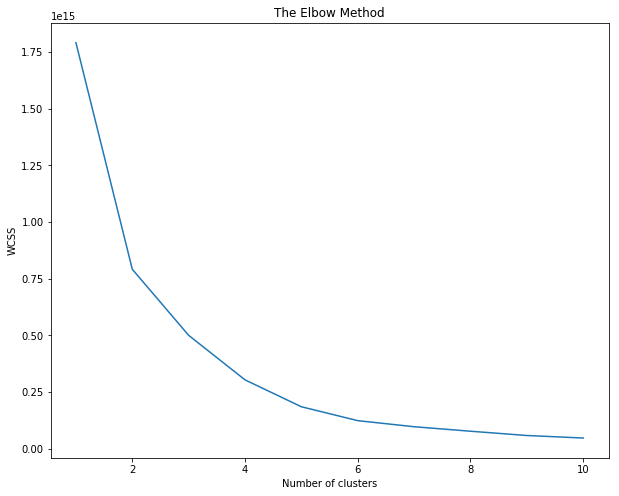

In [45]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
sse={}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(x_prop_kbest)
    sse[i]=kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

En este caso vemos con mayor determinismo que detectaria 2 clases usando el metodo del codo.

Para n_clusters = 2 El silhouette_score promedio es : 0.8496143622366928


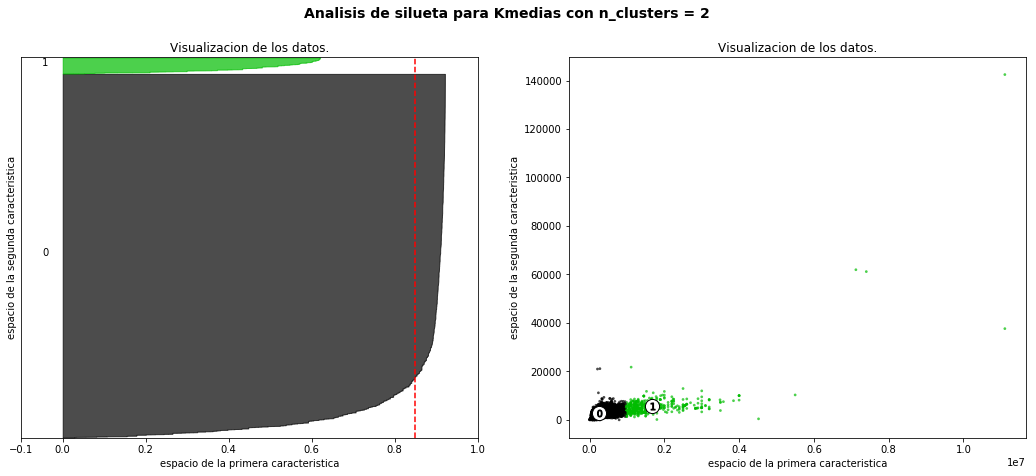

In [46]:
random_state = 42
range_n_clusters = [2]
sse ={}
for clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_prop_kbest) + (clusters + 1) * 10])


    kmeans = KMeans(n_clusters=clusters, random_state=random_state)

    y_pred = kmeans.fit_predict(x_prop_kbest)

    sse[clusters] = kmeans.inertia_
    silhouette_avg = silhouette_score(x_prop_kbest, y_pred)

    print("Para n_clusters =", clusters,
              "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_prop_kbest, y_pred)

    y_lower = 10
    for i in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_pred.astype(float) / clusters)
    ax2.scatter(x_prop_kbest.iloc[:, 0], x_prop_kbest.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
        c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                    "con n_clusters = %d" % clusters),
                    fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)
    plt.show()

Obtuvimos un score de : 0.8496143622366928.
Es muy similar al obtenido con la variable room anteriormente que obtuvimos un score de 0.8496143621819137.

Sigue detectando 2 clases.

In [47]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, random_state = 42)
y_pred = kmeans.fit_predict(x_prop_kbest)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
x_prop_kbest_fin = x_prop_kbest.copy()
x_prop_kbest_fin['cluster_2'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(x_prop_kbest_fin.groupby('cluster_2').count())
kmeans_mean_cluster
#df_prop_t_na.head(50)

,0,1,2,3
cluster_2,,,,
1,11472,11472,11472,11472
2,503,503,503,503


Aplicamos ***PCA*** reduciendo a dimensionalidad de 3

In [48]:
df_prop_PCA = df_prop_t_na.drop("property_type",axis=1)
df_prop_PCA.head()

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,340000.0,2615.384615,130.0,4.0,120.0
1,222000.0,4269.230769,52.0,1.0,48.0
2,1200000.0,2255.639098,532.0,6.0,334.0
3,270000.0,4029.850746,67.0,3.0,64.0
4,250000.0,3731.343284,67.0,2.0,60.0


In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
df_prop_PCA_arr = pca.fit_transform(df_prop_PCA)
df_prop_PCA_tranf = pd.DataFrame(data = df_prop_PCA_arr
                                 , columns = ['principal component 1', 'principal component 2','principal component 3'])
df_prop_PCA_tranf.head(5)

,principal component 1,principal component 2,principal component 3
0,39295.640787,-4.838200,-322.366952
1,-78698.872922,-174.919108,1680.566924
2,899290.746945,391.486853,-3253.787586
3,-30699.806112,-146.096371,1297.817249
4,-50700.613246,-134.150943,1059.715173


In [50]:
df_prop_PCA_tranf_comp = df_prop_PCA_tranf
df_prop_PCA_tranf_comp['property_type']=y_prop

In [51]:
df_prop_PCA_tranf_comp.head()

,principal component 1,principal component 2,principal component 3,property_type
0,39295.640787,-4.838200,-322.366952,1
1,-78698.872922,-174.919108,1680.566924,1
2,899290.746945,391.486853,-3253.787586,2
3,-30699.806112,-146.096371,1297.817249,1
4,-50700.613246,-134.150943,1059.715173,1


Haciendo el plot 3D por color de clase se hace sumamente dificil diferenciar las 3 clases. Prevalece solo 1.

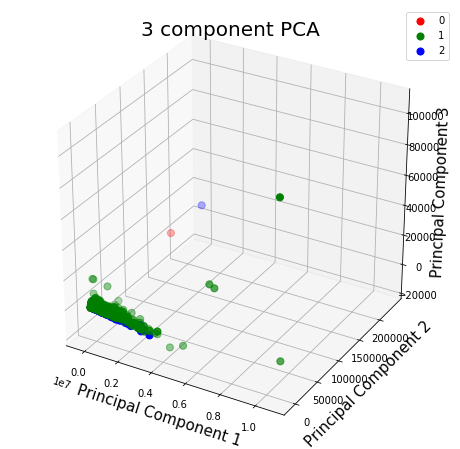

In [52]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_prop_PCA_tranf_comp['property_type'] == target
    ax.scatter(df_prop_PCA_tranf_comp.loc[indicesToKeep, 'principal component 1']
               , df_prop_PCA_tranf_comp.loc[indicesToKeep, 'principal component 2']
               , df_prop_PCA_tranf_comp.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Reducimos la dimensionalidad a 3 componentes y aplicamos el metodo del codo

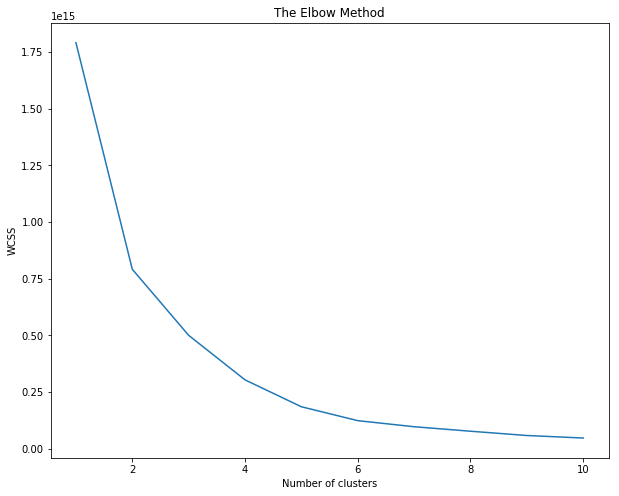

In [53]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
sse={}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_prop_PCA_tranf)
    sse[i]=kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Para n_clusters = 2 El silhouette_score promedio es : 0.8496145599460557


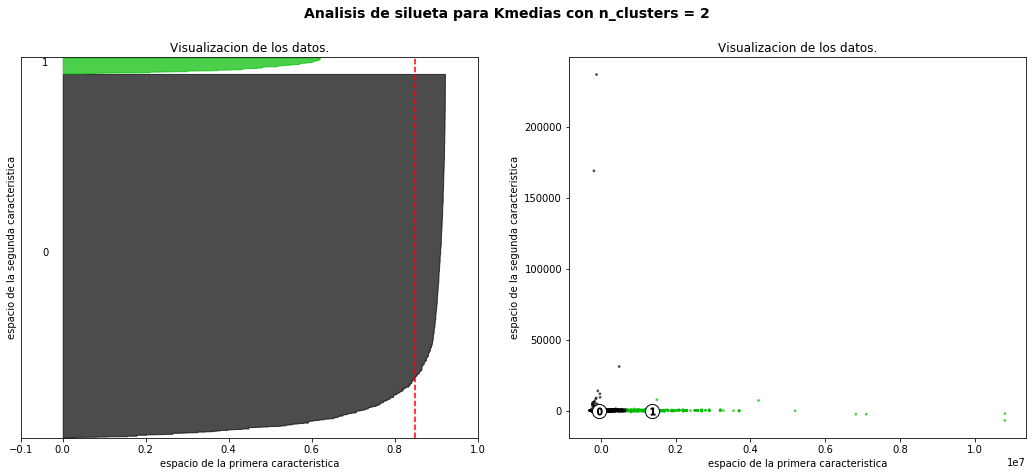

In [54]:
random_state = 42
range_n_clusters = [2]
sse ={}
for clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_prop_PCA_tranf) + (clusters + 1) * 10])


    kmeans = KMeans(n_clusters=clusters, random_state=random_state)

    y_pred = kmeans.fit_predict(df_prop_PCA_tranf)

    sse[clusters] = kmeans.inertia_
    silhouette_avg = silhouette_score(df_prop_PCA_tranf, y_pred)

    print("Para n_clusters =", clusters,
              "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_prop_PCA_tranf, y_pred)

    y_lower = 10
    for i in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_pred.astype(float) / clusters)
    ax2.scatter(df_prop_PCA_tranf.iloc[:, 0], df_prop_PCA_tranf.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
        c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                    "con n_clusters = %d" % clusters),
                    fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)
    plt.show()

Seguimos de la misma manera, detectando 2 clases.

In [55]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, random_state = 42)
y_pred = kmeans.fit_predict(df_prop_PCA_tranf)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
df_prop_PCA_tranf_fin = df_prop_PCA_tranf.copy()
df_prop_PCA_tranf_fin['cluster_2'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(df_prop_PCA_tranf_fin.groupby('cluster_2').count())
kmeans_mean_cluster
#df_prop_t_na.head(50)

,principal component 1,principal component 2,principal component 3,property_type
cluster_2,,,,
1,11472,11472,11472,11472
2,503,503,503,503


*** Ahora probamos balanceando las clases ***

**Oversample**

In [56]:
df_prop_UP_apart = df_prop_t_na[df_prop_t_na['property_type']==1]
df_prop_UP_apart.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,1,340000.0,2615.384615,130.0,4.0,120.0
1,1,222000.0,4269.230769,52.0,1.0,48.0
3,1,270000.0,4029.850746,67.0,3.0,64.0
4,1,250000.0,3731.343284,67.0,2.0,60.0
5,1,490000.0,4900.000000,100.0,4.0,95.0


In [57]:
df_prop_UP_PH = df_prop_t_na[df_prop_t_na['property_type']==0]
df_prop_UP_PH.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
28,0,154000.0,2655.172414,58.0,2.0,58.0
29,0,154000.0,2655.172414,58.0,3.0,58.0
39,0,379000.0,3295.652174,115.0,3.0,99.0
40,0,270000.0,2547.169811,106.0,4.0,80.0
91,0,220000.0,2444.444444,90.0,4.0,84.0


In [58]:
df_prop_UP_house = df_prop_t_na[df_prop_t_na['property_type']==2]
df_prop_UP_house.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
2,2,1200000.0,2255.639098,532.0,6.0,334.0
9,2,1975000.0,4293.478261,460.0,6.0,400.0
30,2,594900.0,2860.096154,208.0,6.0,190.0
65,2,1650000.0,3626.373626,455.0,5.0,456.0
93,2,610000.0,4066.666667,150.0,4.0,118.0


In [59]:
from sklearn.utils import resample
df_prop_UP_house_samp = resample(df_prop_UP_house,
                          replace=True, # sample with replacement
                          n_samples=len(df_prop_UP_apart), # match number in majority class
                          random_state=27) # reproducible results

df_prop_UP_PH_samp = resample(df_prop_UP_PH,
                          replace=True, # sample with replacement
                          n_samples=len(df_prop_UP_apart), # match number in majority class
                          random_state=27) # reproducible results


# combine majority and upsampled minority
df_prop_upsampled = pd.concat([df_prop_UP_house_samp, df_prop_UP_PH_samp,df_prop_UP_apart])


In [60]:
df_prop_upsampled.groupby('property_type').size()

property_type
0    10337
1    10337
2    10337
dtype: int64

In [61]:
df_prop_upsampled_p = df_prop_upsampled.drop('property_type', axis=1)

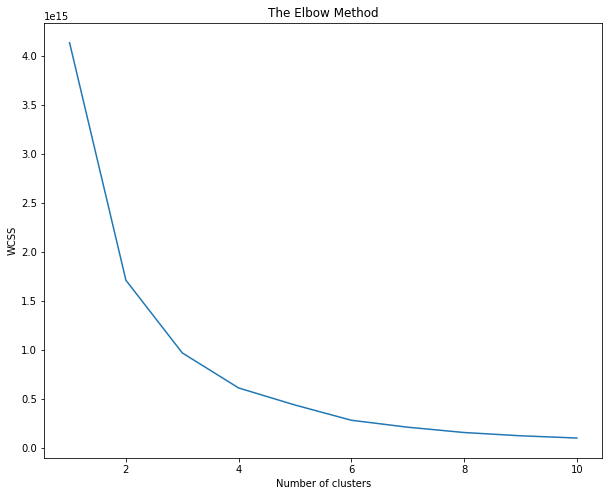

In [62]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
sse={}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_prop_upsampled_p)
    sse[i]=kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Para n_clusters = 2 El silhouette_score promedio es : 0.8512608136987575


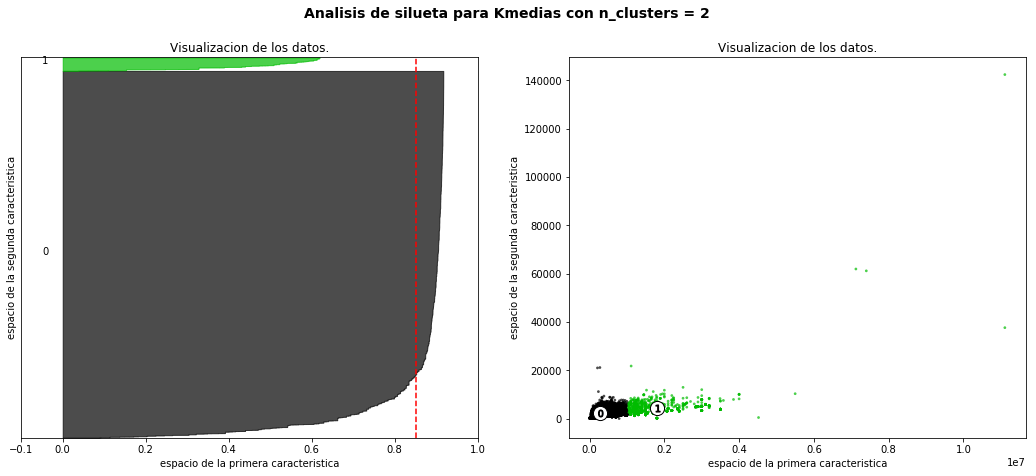

Para n_clusters = 3 El silhouette_score promedio es : 0.7071965986917736


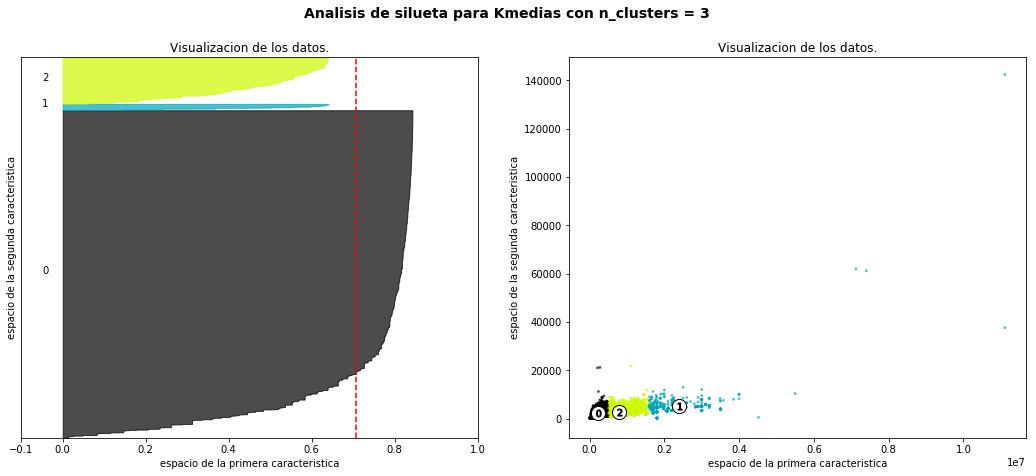

Para n_clusters = 4 El silhouette_score promedio es : 0.6420608546542648


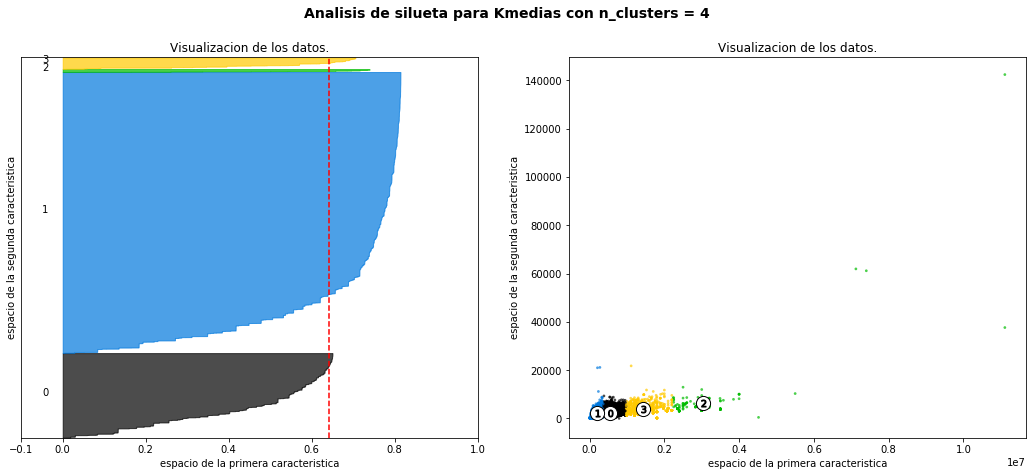

In [63]:
random_state = 42
range_n_clusters = [2,3,4]
sse ={}
for clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_prop_upsampled_p) + (clusters + 1) * 10])


    kmeans = KMeans(n_clusters=clusters, random_state=random_state)

    y_pred = kmeans.fit_predict(df_prop_upsampled_p)

    sse[clusters] = kmeans.inertia_
    silhouette_avg = silhouette_score(df_prop_upsampled_p, y_pred)

    print("Para n_clusters =", clusters,
              "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_prop_upsampled_p, y_pred)

    y_lower = 10
    for i in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_pred.astype(float) / clusters)
    ax2.scatter(df_prop_upsampled_p.iloc[:, 0], df_prop_upsampled_p.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
        c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                    "con n_clusters = %d" % clusters),
                    fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)
    plt.show()

Se sigue observando que la mejor clusterizacion sigue siendo 2 clases. Una que se lleva casi todos los ejemplos y otra con el resto.

In [64]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, random_state = 42)
y_pred = kmeans.fit_predict(df_prop_upsampled_p)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
df_prop_upsampled_p_fin = df_prop_upsampled_p.copy()
df_prop_upsampled_p_fin['cluster_2'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(df_prop_upsampled_p_fin.groupby('cluster_2').count())
kmeans_mean_cluster
#df_prop_t_na.head(50)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
cluster_2,,,,,
1,29465,29465,29465,29465,29465
2,1546,1546,1546,1546,1546


**UNDERSAMPLE**

In [65]:
df_prop_UD_apart = df_prop_t_na[df_prop_t_na['property_type']==1]
df_prop_UD_apart.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,1,340000.0,2615.384615,130.0,4.0,120.0
1,1,222000.0,4269.230769,52.0,1.0,48.0
3,1,270000.0,4029.850746,67.0,3.0,64.0
4,1,250000.0,3731.343284,67.0,2.0,60.0
5,1,490000.0,4900.000000,100.0,4.0,95.0


In [66]:
df_prop_UD_PH = df_prop_t_na[df_prop_t_na['property_type']==0]
df_prop_UD_PH.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
28,0,154000.0,2655.172414,58.0,2.0,58.0
29,0,154000.0,2655.172414,58.0,3.0,58.0
39,0,379000.0,3295.652174,115.0,3.0,99.0
40,0,270000.0,2547.169811,106.0,4.0,80.0
91,0,220000.0,2444.444444,90.0,4.0,84.0


In [67]:
df_prop_UD_house = df_prop_t_na[df_prop_t_na['property_type']==2]
df_prop_UD_house.head()

,property_type,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
2,2,1200000.0,2255.639098,532.0,6.0,334.0
9,2,1975000.0,4293.478261,460.0,6.0,400.0
30,2,594900.0,2860.096154,208.0,6.0,190.0
65,2,1650000.0,3626.373626,455.0,5.0,456.0
93,2,610000.0,4066.666667,150.0,4.0,118.0


In [68]:
from sklearn.utils import resample

df_prop_UD_apart_samp = resample(df_prop_UD_apart,
                          replace=False, # sample with replacement
                          n_samples=len(df_prop_UD_house), # match number in majority class
                          random_state=27) # reproducible results

df_prop_UD_PH_samp = resample(df_prop_UD_PH,
                          replace=False, # sample with replacement
                          n_samples=len(df_prop_UD_house), # match number in majority class
                          random_state=27) # reproducible results


# combine majority and upsampled minority
df_prop_undersample = pd.concat([df_prop_UD_apart_samp, df_prop_UD_PH_samp,df_prop_UD_house])
df_prop_undersample = df_prop_undersample.reset_index(drop=True)

In [69]:
df_prop_undersample.groupby('property_type').size()

property_type
0    648
1    648
2    648
dtype: int64

In [70]:
df_prop_undersample_p = df_prop_undersample.drop('property_type', axis=1)

In [71]:
df_prop_undersample_p.head(5)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
0,1600000.0,5144.694534,311.0,7.0,311.0
1,212000.0,2185.567010,97.0,4.0,87.0
2,100000.0,3125.000000,32.0,1.0,29.0
3,173500.0,2940.677966,59.0,2.0,52.0
4,178700.0,4155.813953,43.0,2.0,35.0


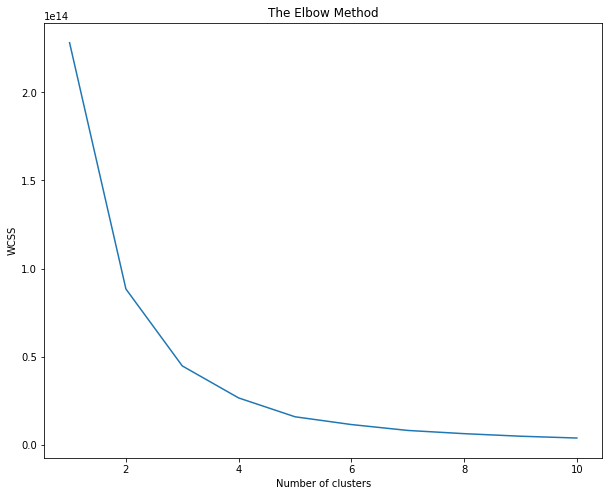

In [72]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
sse={}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df_prop_undersample_p)
    sse[i]=kmeans.inertia_
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Para n_clusters = 2 El silhouette_score promedio es : 0.839823540221278


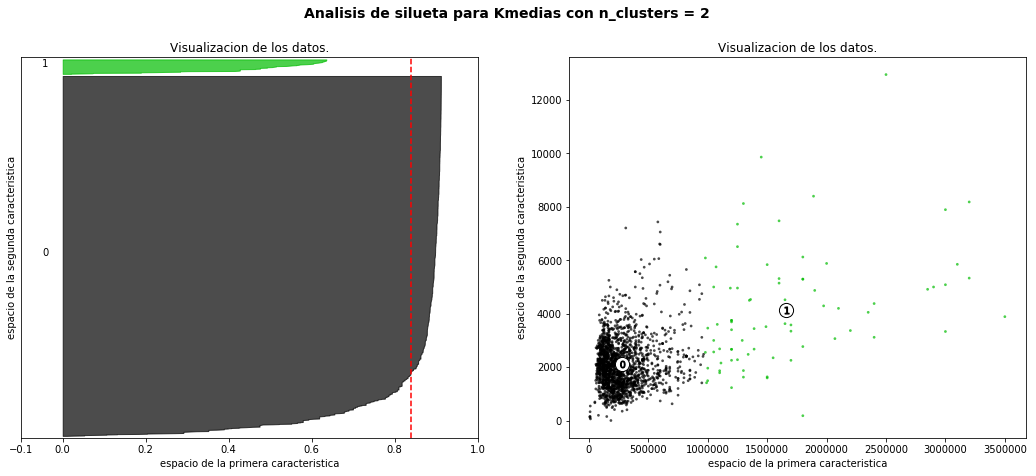

Para n_clusters = 3 El silhouette_score promedio es : 0.6942324267129887


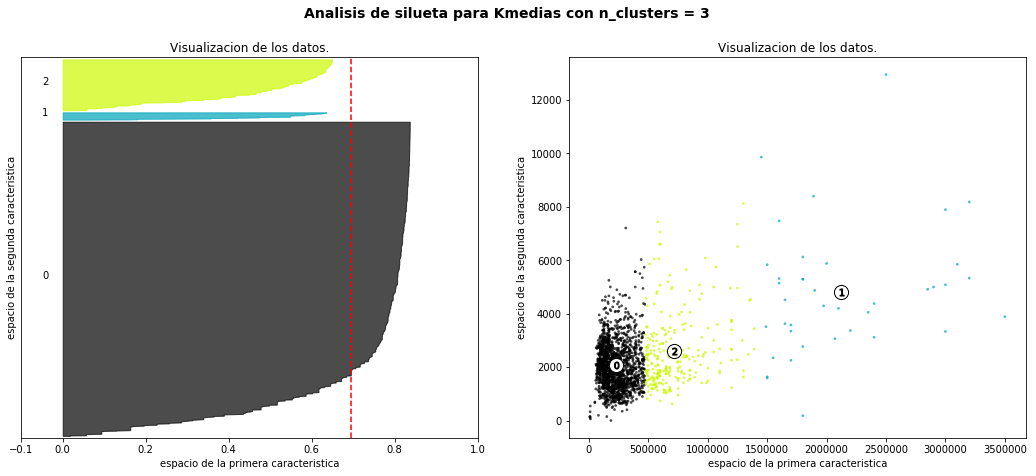

Para n_clusters = 4 El silhouette_score promedio es : 0.6376365953913814


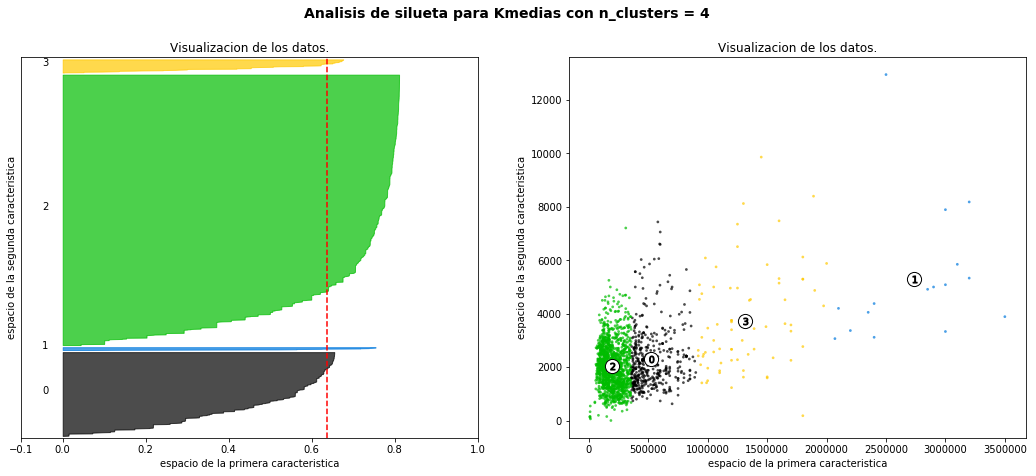

In [73]:
random_state = 42
range_n_clusters = [2,3,4]
sse ={}
for clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_prop_undersample_p) + (clusters + 1) * 10])


    kmeans = KMeans(n_clusters=clusters, random_state=random_state)

    y_pred = kmeans.fit_predict(df_prop_undersample_p)

    sse[clusters] = kmeans.inertia_
    silhouette_avg = silhouette_score(df_prop_undersample_p, y_pred)

    print("Para n_clusters =", clusters,
              "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_prop_undersample_p, y_pred)

    y_lower = 10
    for i in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_pred.astype(float) / clusters)
    ax2.scatter(df_prop_undersample_p.iloc[:, 0], df_prop_undersample_p.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
        c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                    "con n_clusters = %d" % clusters),
                    fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)
    plt.show()

Se observa misma diferencias de clases. 1 gran clase y el resto.

In [74]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, random_state = 42)
y_pred = kmeans.fit_predict(df_prop_undersample_p)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_pred
y_kmeans1=y_pred+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
df_prop_undersample_p_fin = df_prop_undersample_p.copy()
df_prop_undersample_p_fin['cluster_2'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(df_prop_undersample_p_fin.groupby('cluster_2').count())
kmeans_mean_cluster
#df_prop_t_na.head(50)

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,rooms,surface_covered_in_m2
cluster_2,,,,,
1,1868,1868,1868,1868,1868
2,76,76,76,76,76


# Informe final

Presentar un informe final con los datos inferidos del dataset utilizando herramientas gráficas y escritas teniendo en cuenta los destinatarios. En este caso colegas de la diplomatura para preparar el informe con un background adecuado al destinatario.